In [21]:
import sys

In [22]:
sys.path.insert(1,'../../')

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import genhelper.vcf_helper as vhelper
from sklearn.metrics import r2_score
import zarr

In [24]:
vcfpath = './raw/G1K_chr22.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
raw_callset = zarr.open_group(zarr_path)

In [25]:
raw_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [26]:
vcfpath = './interim/G1K_chr22_biallelic.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
biallelic_callset = zarr.open_group(zarr_path)

In [27]:
biallelic_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [28]:
vcfpath = './test/G1K_chr22_biallelic_predict.dose.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
predict_callset = zarr.open_group(zarr_path)

In [29]:
predict_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [30]:
vcfpath = './test/G1K_chr22_biallelic_gtruth.recode.vcf.gz'
zarr_path = vhelper.vcf_to_zarr(vcfpath)
gtruth_callset = zarr.open_group(zarr_path)

In [31]:
gtruth_callset.tree(expand=True)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

In [32]:
def maf_cal(x):
    return x if x < 0.5 else 1-x
xindex_col = 'PINDEX'
poss_name = 'POS'
alt_name = 'ALT'
af_name = 'AF'
predict_data = pd.DataFrame({
    poss_name : predict_callset.variants.POS[:],
    alt_name : predict_callset.variants.ALT[:,0],
    xindex_col : np.arange(predict_callset.variants.POS.size,dtype=int)
})
yindex_col = 'GINDEX'
gtruth_data = pd.DataFrame({
    poss_name : gtruth_callset.variants.POS[:],
    alt_name : gtruth_callset.variants.ALT[:,0],
    yindex_col : np.arange(gtruth_callset.variants.POS.size,dtype=int),
})
panel_data = pd.DataFrame({
    poss_name : biallelic_callset.variants.POS[:],
    alt_name : biallelic_callset.variants.ALT[:,0],
    af_name : biallelic_callset.variants.AF[:,0]
})
panel_data['AF'] = panel_data['AF'].apply(maf_cal)
panel_data.rename(columns={'AF': 'MAF'},inplace=True)

In [33]:
# Lấy ra dữ liệu và cho biết dữ liệu đó tồn tại ở cùng hay 1 bên của bảng
concat_data = gtruth_data.merge(panel_data, on=['POS','ALT'], how='inner', indicator=True)
concat_data.drop(columns=['_merge'],inplace=True)
concat_data = concat_data.merge(predict_data,on=['POS','ALT'], how='inner', indicator=True)
del gtruth_data
del predict_data
del panel_data

In [78]:
def r2_score_by_bin(labels,bin_name,df,xindex_col,yindex_col,xgt,ygt):
    r2_scores = []
    nb_var = []
    for label in labels:
        temp = df[df[bin_name] == label]
        xindexs = temp[xindex_col].values
        yindexs = temp[yindex_col].values
        r2_ = r2_score(ygt[yindexs],xgt[xindexs])
        r2_scores.append(r2_)
        nb_var.append(temp.shape[0])
    r2_scores = np.array(r2_scores)
    nb_var = np.array(nb_var)
    return r2_scores, nb_var

In [79]:
bins = np.array([0,0.001,0.005,0.01,0.05,0.2,0.5])
ticks = np.arange(1,len(bins))
labels = bins[1:]
bin_name = 'bin'
concat_data[bin_name] = pd.cut(concat_data['MAF'],bins=bins,labels=labels)

In [80]:
xgt = predict_callset.calldata.GT[:]
xgt = xgt.reshape((xgt.shape[0],xgt.shape[1]*2))
ygt = gtruth_callset.calldata.GT[:]
ygt = ygt.reshape((ygt.shape[0],ygt.shape[1]*2))
r2_maf, nb_var = r2_score_by_bin(labels,bin_name,concat_data,xindex_col,yindex_col,xgt,ygt)

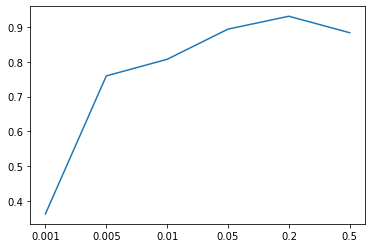

In [81]:
plt.plot(ticks,r2_maf)
plt.xticks(ticks=ticks,labels=labels)
plt.show()

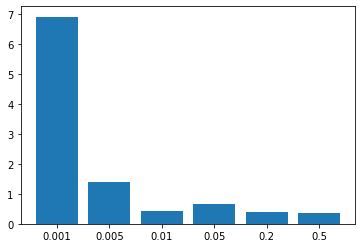

In [91]:
plt.bar(ticks,nb_var/100000)
plt.xticks(ticks=ticks,labels=labels)
plt.show()

In [86]:
xds = predict_callset.calldata.DS[:]
yds = gtruth_callset.calldata.GT[:].sum(axis=2)
r2_maf, nb_var = r2_score_by_bin(labels,bin_name,concat_data,xindex_col,yindex_col,xds,yds)

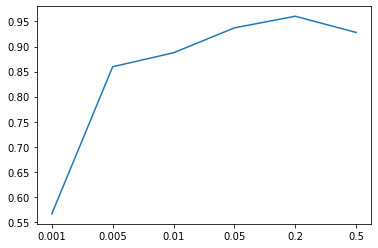

In [87]:
plt.plot(ticks,r2_maf)
plt.xticks(ticks=ticks,labels=labels)
plt.show()

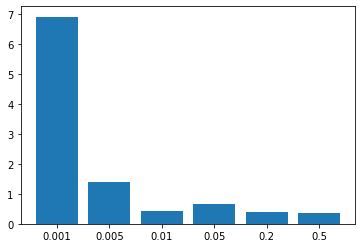

In [90]:
plt.bar(ticks,nb_var/100000)
plt.xticks(ticks=ticks,labels=labels)
plt.show()